# 1.Imports

In [43]:

# quimb import
import quimb.tensor as qtn
import quimb as qu
from quimb import randn
import numpy as np
from quimb.tensor.optimize import TNOptimizer
import jax.numpy as jnp
# tenpy imports
import tenpy as tp
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
import matplotlib.pyplot as plt
# thermal state imports
#from hamiltonian import model_mpo
import scipy.linalg as la

# 2. Thermal-state functions

In [2]:
def qmps_f(L=16, in_depth=2, n_Qbit=3, data_type='float64', qmps_structure="pollmann", canon="left", seed_init=10):

    seed_val=seed_init

    list_u3=[]
    n_apply=0
    circ = qtn.Circuit(L)

    if canon=="left":
        for i in range(0,L-n_Qbit,1):
            Qubit_ara=i+n_Qbit
            if qmps_structure=="pollmann":
                n_apply, list_u3=range_su4_pollmann(circ, i, n_apply, list_u3, in_depth, n_Qbit,data_type,seed_val, Qubit_ara)
    return circ, list_u3

def range_su4_pollmann(circ, i_start, n_apply, list_u3, depth, n_Qbit,data_type,seed_val,Qubit_ara):
    gate_round=None
    if n_Qbit==0: depth=1
    if n_Qbit==1: depth=1
    c_val=0
    for r in range(depth):
        for i in range(i_start, i_start+n_Qbit, 1):
         #print("U_e", i, i + 1, n_apply)
            param = qu.randn(15, dist='uniform')
            circ.apply_gate('SU4',*param,i,i+1,gate_round=None, parametrize=True,contract=False)#,tags={'U',f'G{n_apply}',f'lay{Qubit_ara}',f'P{Qubit_ara}L{i}D{r}'})
            list_u3.append(f'G{n_apply}')
            n_apply+=1
            c_val+=1

    return n_apply, list_u3

def MPDO(circuit,dm,n,j):
    """
    Constructs the Matrix Product Density Operator
    """
    k = circuit
    k = k.reindex({'k0':f'b{n+1}', 'k1':f'p{j}', 'b0':f'b{n}', 'b1':f'p{j+2}'})
    
    dm1 = dm.reindex({'b1':f'p{j+1}','kc0':f'p{j+2}'})
    #dm1 = dm.reindex({'kc0':f'p{j+2}',})

    kc = circuit.conj()
    kc = kc.reindex({'k0':f'bx{n+1}','k1':f'p{j+3}','b0':f'bx{n}','b1':f'p{j+1}'})
    
    TN = k & dm1 & kc  
    return TN


def contract(circuit,dm):
    """
    Contracts one site of MPDO
    """
    k = circuit
    k = k.reindex({'k0':f'b1', 'k1':f'p0', 'b0':f'b0', 'b1':f'p1'})
    
    dm1 = dm.reindex({'b1':f'p2','kc0':f'p1'})

    kc = circuit.H
    kc = kc.reindex({'k0':f'bx1','k1':f'p0','b0':f'bx0','b1':f'p2'})
    
    TN = k & dm1 & kc
    return TN


def density_contract(circuit,N,bc,state_vcl=None,chi=None):
    """
    Returns tensor contractions (for density matrix chain)
    """
    dm = density_matrix(pre_meas())
    TN_list = [MPDO(circuit,dm,n,j) for n,j in zip(range(N),range(0,4*N+N,5))]
    
    # for MPDO
    if bc == 'finite':
        # boundary conditions
        # for ket:
        inds0 = 'b0',
        s_left = qtn.Tensor(state_vcl,inds0,tags='sl')
        
        # for bra:
        inds2 = 'bx0',
        sc_left = qtn.Tensor(state_vcl.conj(),inds2,tags='scl')
    
        #inds1 = f'b{N}',f'bx{N}',
        #s_right = qtn.Tensor(np.eye(state_vcl.size),inds1,tags='rvec')

        # tenor contractions
        TN0 = TN_list[0]
        for j in range(1,len(TN_list)):
            TN0 = TN_list[j] & TN0
        
        #TN1 = s_left & s_right & sc_left & TN0
        TN = s_left & sc_left & TN0 
        TN1 = TN.reindex({f'b{N}':'e',f'bx{N}':'e'})
    
    # for iMPDO
    elif bc == 'infinite':
        
        # tenor contractions
        TN0 = TN_list[0]
        for j in range(1,len(TN_list)):
            TN0 = TN_list[j] & TN0
    
        # transfer matrix construction
        transfer_mat = np.reshape(np.einsum('abcd->acbd',contract(circuit,dm).contract().data),[4,4])
        eig_vals,eig_vecs = la.eig(transfer_mat)
        idx = np.where(np.abs(1-abs(eig_vals))<1e-10)[0][0]
        steady_den = np.reshape(eig_vecs[:,idx],[chi,chi])
        bvecl = steady_den/np.trace(steady_den)
    
        inds2 = 'b0','bx0',
        s_left = qtn.Tensor(bvecl,inds2,tags='steady-state')
    
        TN = s_left & TN0
        TN1 = TN.reindex({f'b{N}':'e',f'bx{N}':'e'})
        
    return TN1


def pre_meas():
    '''
    A circuit to prepare unitary circuit that we use for density operator
    '''
    rng = np.random.default_rng()
    params = rng.uniform(low=1.5,high=2,size = 1)
    circ = qtn.Circuit(2)
    if T == 0:
        m = np.exp(-1/1e-32)
    else:
        m = np.exp(-1/T)
    circ.apply_gate('RX', *params*m, 0,
            gate_round=None,parametrize=True)
    circ.apply_gate('CNOT',0,1,
            gate_round=None,parametrize=False)
    return circ


def density_matrix(unitary_circ):
    '''
    Here we prepare the density matrix
    '''
    a = unitary_circ.uni
    ini = np.zeros([4,4])
    ini[0][0]=1
    ini = ini.reshape(2,2,2,2)
    ind = 'k0','bc0','k1','bc1'
    den = qtn.Tensor(ini,ind,tags='den')
    b = a.conj().reindex({'k0':'bc0','b0':'kc1','b1':'kc0','k1':'bc1'})
    TN = a & den & b
    TN = TN.reindex({'b0':'x','kc1':'x'})
    #ind2 = 'b1',
    #u = qtn.Tensor(np.array([1,1]),ind2)
    #TN1 = u & TN
    return TN


def entropy(prob_list):
    """
    Returns the entropy
    """ 
    # avoiding NaN in numpy.log() function
    new_prob_list = []
    for j in prob_list:
        new_prob_list.append(j+1.e-30)
    s_list = [-p*jnp.log(p) for p in new_prob_list]
    s = sum(s_list) # entropy
    return s.real


# 3. Hamiltonian

In [3]:

# params of model
J = 1
g = 0
h = 1

In [4]:

# DMRG calculations

"""Prototypical example of a quantum model: the transverse field Ising model.
Like the :class:`~tenpy.models.xxz_chain.XXZChain`, the transverse field ising chain
:class:`TFIChain` is contained in the more general :class:`~tenpy.models.spins.SpinChain`;
the idea is more to serve as a pedagogical example for a 'model'.
We choose the field along z to allow to conserve the parity, if desired.
"""
# Copyright 2018-2020 TeNPy Developers, GNU GPLv3

__all__ = ['TFIModel', 'TFIChain']


class TFIZModel(CouplingMPOModel):
    r"""Transverse field Ising model on a general lattice.
    The Hamiltonian reads:
    .. math ::
        H = - \sum_{\langle i,j\rangle, i < j} \mathtt{J} \sigma^x_i \sigma^x_{j}
            - \sum_{i} \mathtt{g} \sigma^z_i
    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs, each pair appearing
    exactly once.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`TFIModel` below.
    Options
    -------
    .. cfg:config :: TFIModel
        :include: CouplingMPOModel
        conserve : None | 'parity'
            What should be conserved. See :class:`~tenpy.networks.Site.SpinHalfSite`.
        J, g : float | array
            Coupling as defined for the Hamiltonian above.
    """
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinHalfSite(conserve=conserve)
        return site

    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.))
        g = np.asarray(model_params.get('g', 1.))
        h = np.asarray(model_params.get('h', 1.))
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-g, u, 'Sigmaz')
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-h, u, 'Sigmax')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-J, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        # done

class TFIZChain(TFIZModel, NearestNeighborModel):
    """The :class:`TFIModel` on a Chain, suitable for TEBD.
    See the :class:`TFIModel` for the documentation of parameters.
    """
    def __init__(self, model_params):
        model_params = asConfig(model_params, self.__class__.__name__)
        model_params.setdefault('lattice', "Chain")
        CouplingMPOModel.__init__(self, model_params)
        
def DMRG_tfim(J,g,h,chi_max,bc,L,verbose=False):
    model_params = dict(L=L, J=J, g=g, h=h, bc_MPS=bc, conserve=None, verbose=verbose)
    M = TFIZChain(model_params)
    product_state = ["down"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-6
        },
        'max_E_err': 1.e-6,
        'verbose': verbose,
    }
    # Sometimes, we want to call a 'DMRG engine' explicitly
    eng = tp.algorithms.dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    #print("correlation length:", psi.correlation_length())
    if bc == 'infinite':
        E1 = E
    else:
        E1 = E/L
    return E1

In [5]:

# Hamiltonian functions
def tfim_ising(J, g, h, N, bc):
    """
    Unit-cell matrix product operator of Transverse 
    Field Ising model (TFIM). 
    """
    if bc == 'infinite':
        J, g, h = J/(N-1),g/N,h/N
    elif bc == 'finite':
        J, g, h = J/N,g/N,h/N
    # Pauli matrices 
    sigmax = np.array([[0., 1], [1, 0.]])
    sigmay = np.array([[0., -1j], [1j, 0.]])
    sigmaz = np.array([[1, 0.], [0., -1]])
    id = np.eye(2)
    
    # structure of TFIM Ising model MPO unit cell
    H = np.zeros((3, 3, 2, 2))
    H[0, 0] = H[2, 2] = id
    H[1, 0] = sigmaz
    H[2, 0] = (-g * sigmaz - h * sigmax)
    H[2, 1] = (-J * sigmaz)
    H1 = np.einsum('abcd->cbda',H)
    return H1 

def H(Hamiltonian,n,j):
    inds4 = f'p{j}',f'H{n+1}',f'p{j+3}',f'H{n}'
    H = qtn.Tensor(Hamiltonian,inds4,tags='H')
    return H

def H_contract(Hamiltonian,N,H_bvecl,H_bvecr):
    """
    Returns tensor contractions of Hamiltonian
    """
    TN_list = [H(Hamiltonian,n,j) for n,j in zip(range(N),range(0,4*N+N,5))]
    
    # for Hamiltonian
    inds4 = 'H0',
    H_left = qtn.Tensor(H_bvecl,inds4,tags='Hl')
    inds5 = f'H{N}',
    H_right = qtn.Tensor(H_bvecr,inds5,tags='Hr')

    # tenor contractions
    TN0 = TN_list[0]
    for j in range(1,len(TN_list)):
        TN0 = TN_list[j] & TN0
    
    TN = H_left & H_right & TN0
    return TN

In [6]:

Hamiltonian = tfim_ising(J,g,h,10,bc='infinite')
chi_H = Hamiltonian[0,:,0,0].size # size of Hamiltonian bond leg dimension

# boundary conditions
H_bvecl = np.zeros(chi_H)
H_bvecr = np.zeros(chi_H)
H_bvecr[0] = 1.
H_bvecl[-1] = 1.
bdry_vecs2 = [H_bvecl,H_bvecr]

In [7]:

# circuit structure
def add_su4(param):
    circ = qtn.Circuit(2)
    circ.apply_gate('SU4',*param,0,1,gate_round=None, parametrize=True,contract=False)
    return circ

# 4. MPDO sims

In [33]:

# params
T = 1
l_uc = 1
L = 10
N = L * l_uc
chi = 2

In [34]:

# defining state (TN) and hamiltonian
#E_finite = DMRG_tfim(J,g,h,chi_max=chi,bc='finite',L=L,verbose=False)
Hamiltonian = tfim_ising(J,g,h,N,bc='finite')
U = H_contract(Hamiltonian,N,H_bvecl,H_bvecr)
#ind = 'b1','kc0'
#dm = qtn.Tensor(np.array([[1,0],[0,0]]),ind)
state_vcl = np.array([1.,0.])
param = qu.randn(15, dist='uniform')
#circuit = add_su4_circ(0,1,param).uni
circuit = add_su4(param).uni
V = density_contract(circuit,N,'finite',state_vcl,chi)

In [72]:
Hamiltonian = tfim_ising(J,g,h,N,bc='finite')
U = H_contract(Hamiltonian,N,H_bvecl,H_bvecr)
U.tensors

(Tensor(shape=(3,), inds=('H0',), tags=oset(['Hl'])),
 Tensor(shape=(3,), inds=('H10',), tags=oset(['Hr'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p45', 'H10', 'p48', 'H9'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p40', 'H9', 'p43', 'H8'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p35', 'H8', 'p38', 'H7'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p30', 'H7', 'p33', 'H6'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p25', 'H6', 'p28', 'H5'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p20', 'H5', 'p23', 'H4'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p15', 'H4', 'p18', 'H3'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p10', 'H3', 'p13', 'H2'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p5', 'H2', 'p8', 'H1'), tags=oset(['H'])),
 Tensor(shape=(2, 3, 2, 3), inds=('p0', 'H1', 'p3', 'H0'), tags=oset(['H'])))

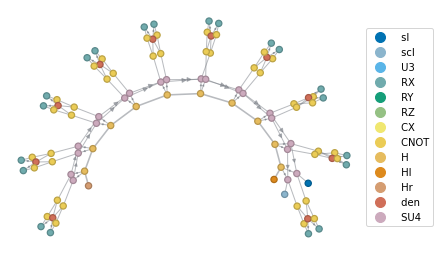

In [49]:

def prob(V):
    p1 = V['RX','GATE_0'][0].data[0][0]**2
    p2 = 1-p1
    prob_list = [p1,p2]
    return prob_list
# free energy

def loss(V,U,T):
    """
    Represents the free energy function
    """
    TN = (V & U).rank_simplify()
    prob_list = prob(V)
    E = np.real((TN).contract(all, optimize='auto-hq',backend = 'jax'))
    S = entropy(prob_list)
    F = E - T*S
    return F

(U & V).draw(color=['sl','scl','U3','RX','RY','RZ','CX','CNOT','H','Hl','Hr','den','SU4'])

In [57]:

# case 1 "setting as shared_tags"
tnopt = TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U,'T':T},  # supply U to the loss function as a constant TN
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='tnc',     # the optimization algorithm
    shared_tags=['SU4','RX'],
   # executor=add_su4
)
v_opt = tnopt.optimize(1000,jac=True)
#print(f'DMRG estimation for finite length of L = {L}: {E_finite}')

/opt/anaconda3/lib/python3.8/site-packages/quimb/tensor/optimize.py:283: UserWarning: TNOptimizer warning, some `shared_tags` are missing from `tags`. Automatically adding these missing `shared_tags` to `tags`.
  warnings.warn('TNOptimizer warning, some `shared_tags` are missing'
-2.381868362427 [best: -2.381868362427] :  53%|█████▎    | 528/1000 [00:29<00:25, 18.17it/s] 


In [73]:
T

3.0000000000000004

In [22]:

#case 2 "setting as tags"
tnopt = TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U,'T':T},  # supply U to the loss function as a constant TN
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='tnc',     # the optimization algorithm
    tags=['SU4','RX'],
   # executor=add_su4
)
v_opt = tnopt.optimize(10000,jac=True)

-6.753520965576 [best: -6.753520965576] :  26%|██▌       | 2601/10000 [00:48<02:18, 53.27it/s]  


In [67]:
v_opt.tensors

(Tensor(shape=(2,), inds=('b0',), tags=oset(['sl'])),
 Tensor(shape=(2,), inds=('bx0',), tags=oset(['scl'])),
 PTensor(shape=(2, 2, 2, 2), inds=('b9', 'p47', 'e', 'p45'), tags=oset(['SU4', 'GATE_0', 'I0', 'I1'])),
 PTensor(shape=(2, 2), inds=('_a887aeAAAHJ', 'k0'), tags=oset(['RX', 'GATE_0', 'I0'])),
 Tensor(shape=(2, 2, 2), inds=('x', '_a887aeAAAHJ', '_a887aeAAAHL'), tags=oset(['CNOT', 'GATE_1', 'I0'])),
 Tensor(shape=(2, 2, 2), inds=('_a887aeAAAHL', 'p46', 'k1'), tags=oset(['CNOT', 'GATE_1', 'I1'])),
 Tensor(shape=(2, 2, 2, 2), inds=('k0', 'bc0', 'k1', 'bc1'), tags=oset(['den'])),
 PTensor(shape=(2, 2), inds=('_a887aeAAAHN', 'bc0'), tags=oset(['RX', 'GATE_0', 'I0'])),
 Tensor(shape=(2, 2, 2), inds=('x', '_a887aeAAAHN', '_a887aeAAAHO'), tags=oset(['CNOT', 'GATE_1', 'I0'])),
 Tensor(shape=(2, 2, 2), inds=('_a887aeAAAHO', 'p47', 'bc1'), tags=oset(['CNOT', 'GATE_1', 'I1'])),
 PTensor(shape=(2, 2, 2, 2), inds=('bx9', 'p46', 'e', 'p48'), tags=oset(['SU4', 'GATE_0', 'I0', 'I1'])),
 PTensor(

In [32]:

# theoretical predictions (applications of Jordan-Wigner transformations):
def theory_free_energy(case_type, N, J, g, T):
    """
    case_type: One of "ferromagnetic" or "anti-ferromagnetic" options.
    N : total number of lattice sites (must be even/odd for ferromagnetic/anti-ferromagnetic case).
    For more detail, see  Y. He and H. Guo, J. Stat. Mech. (2017) 093101.
    """
    a_list = []
    p_list = [] 
    E = lambda J,g,k: np.sqrt((J/2)**2 + g**2 + J*g*np.cos(k)) # dispersion relation
    
    # for ferromagnetic TFIM case:
    if case_type == 'ferromagnetic':     
        
        if N % 2 != 0: # checking whether N is even
            raise ValueError('for ferromagnetic case, N must be even')
        
        # anti-periodic boundary condition (ABC) k-values
        for j in range(1,N):
            while ((2*j-1)*(np.pi)/N) <= ((N-1)*(np.pi)/N):
                a_list.append((2*j-1)*(np.pi)/N)
                a_list.append(-(2*j-1)*(np.pi)/N)
                break
                
        # periodic boundary condition (PBC) k-values
        for j in range(1,N):
            while (2*j)*(np.pi)/N <= ((N-2)*(np.pi)/N):
                p_list.append((2*j)*(np.pi)/N)
                p_list.append(-(2*j)*(np.pi)/N)
                break
        p_list.append(0)
        p_list.append(np.pi)
        
        # calculations of partition functions for PBC (Zp1 & Zp2) and APBC (Za1 & Za2) contributions
        p1,p2,a1,a2 = [],[],[],[]
        for kp,ka in zip(p_list,a_list):         
            xp = E(J,g,kp)/(2*T)
            xa = E(J,g,ka)/(2*T)  
            p1.append(np.exp(xp) + np.exp(-xp))
            p2.append(np.exp(xp) - np.exp(-xp))
            a1.append(np.exp(xa) + np.exp(-xa))
            a2.append(np.exp(xa) - np.exp(-xa))
            
        # partition functions
        Zp1 = np.prod(p1)
        Zp2 = np.prod(p2)
        Za1 = np.prod(a1)
        Za2 = np.prod(a2)
            
        # total partition function for ferromagnetic case    
        Z_FM = (1/2)*(Za1 + Za2 + Zp1 - (np.sign(g - J/2))*Zp2) 
        F = -(T/N)*np.log(Z_FM) # free energy (ferromagnetic case)
    
    # for anti-ferromagnetic TFIM case:
    elif case_type == 'anti-ferromagnetic':    
        
        if N % 2 == 0: # checking whether N is odd
            raise ValueError('for anti-ferromagnetic case, N must be odd')
        
        # anti-periodic boundary condition (ABC) k-values
        for j in range(1,N):
            while ((2*j-1)*(np.pi)/N) <= ((N-2)*(np.pi)/N):
                a_list.append((2*j-1)*(np.pi)/N)
                a_list.append(-(2*j-1)*(np.pi)/N)
                break
        a_list.append(np.pi)       
        
        # periodic boundary condition (PBC) k-values
        for j in range(1,N):
            while (2*j)*(np.pi)/N <= ((N-1)*(np.pi)/N):
                p_list.append((2*j)*(np.pi)/N)
                p_list.append(-(2*j)*(np.pi)/N)
                break
        p_list.append(0)
               
        # calculations of partition functions for PBC (Zp1 & Zp2) and APBC (Za1 & Za2) contributions
        p1,p2,a1,a2 = [],[],[],[]
        for kp,ka in zip(p_list,a_list):         
            xp = E(J,g,kp)/(2*T)
            xa = E(J,g,ka)/(2*T)  
            p1.append(np.exp(xp) + np.exp(-xp))
            p2.append(np.exp(xp) - np.exp(-xp))
            a1.append(np.exp(xa) + np.exp(-xa))
            a2.append(np.exp(xa) - np.exp(-xa))
            
        # partition functions
        Zp1 = np.prod(p1)
        Zp2 = np.prod(p2)
        Za1 = np.prod(a1)
        Za2 = np.prod(a2)
        
        # total partition function for anti-ferromagnetic case
        Z_AFM = (1/2)*(Za1 - Za2 + Zp1 + (np.sign(g - abs(J)/2))*Zp2) 
        F = -(T/N)*np.log(Z_AFM) # free energy (anti-ferromagnetic case)   
    else:
        raise ValueError('only one of "ferromagnetic" or "anti-ferromagnetic" options')
    return F

F_theory = theory_free_energy('ferromagnetic',12,J*4,h*2,1)
F_theory

-1.4157687365877687

In [42]:
Tlist = np.arange(0.2,3.2,0.2)
quimb_results = []

for T in Tlist:
    tnopt = TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U,'T':T},  # supply U to the loss function as a constant TN
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='tnc',     # the optimization algorithm
    shared_tags=['SU4','RX'],
)
    v_opt = tnopt.optimize(2000,jac=True)
    quimb_results.append(loss(v_opt,U,T))


-2.381868362427 [best: -2.381868362427] :  26%|██▋       | 528/2000 [00:17<00:49, 29.60it/s] 


In [45]:
exact_results = []
for T in Tlist:
    exact_results.append(theory_free_energy('ferromagnetic',12,J*4,h*2,T))

In [77]:
np.array(quimb_results)

array([-1.2078961, -1.2251863, -1.2276006, -1.2669147, -1.3176906,
       -1.3840051, -1.468862 , -1.563732 , -1.6665193, -1.7751042,
       -1.8888035, -2.0025725, -2.1270645, -2.2539494, -2.3818672],
      dtype=float32)

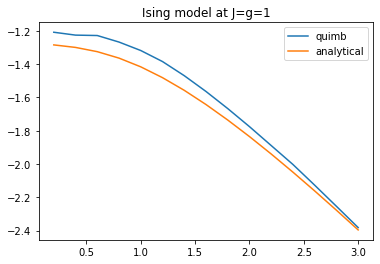

In [47]:
plt.plot(Tlist,quimb_results)
plt.plot(Tlist,exact_results)
plt.title('Ising model at J=g=1')
plt.legend(['quimb','analytical'])

Running log

-1.207898259163 [best: -1.207898259163] :  14%|█▎        | 270/2000 [00:17<01:55, 15.01it/s]
-1.225187659264 [best: -1.225187659264] :  41%|████▏     | 828/2000 [00:18<00:25, 45.08it/s] 
-1.227605938911 [best: -1.227605938911] :  31%|███▏      | 627/2000 [00:18<00:39, 34.78it/s] 
-1.266918182373 [best: -1.266918182373] :  50%|█████     | 1007/2000 [00:18<00:17, 55.37it/s] 
-1.317694187164 [best: -1.317694187164] :  39%|███▊      | 773/2000 [00:18<00:28, 42.32it/s] 
-1.384006738663 [best: -1.384006738663] :  36%|███▌      | 723/2000 [00:17<00:31, 40.31it/s] 
-1.468864917755 [best: -1.468864917755] :  16%|█▌        | 315/2000 [00:17<01:31, 18.37it/s] 
-1.563734292984 [best: -1.563734292984] :  30%|██▉       | 596/2000 [00:17<00:42, 33.29it/s] 
-1.666520953178 [best: -1.666520953178] :  25%|██▌       | 505/2000 [00:21<01:05, 22.96it/s]  
-1.775105834007 [best: -1.775105834007] :  23%|██▎       | 468/2000 [00:18<00:59, 25.60it/s] 
-1.888804674149 [best: -1.888804674149] :  29%|██▉       | 588/2000 [00:17<00:42, 33.17it/s] 
-2.002572774887 [best: -2.002572774887] :  14%|█▍        | 280/2000 [00:17<01:47, 16.03it/s] 
-2.127065420151 [best: -2.127065420151] :  22%|██▏       | 449/2000 [00:17<01:00, 25.44it/s] 
-2.253951072693 [best: -2.253951072693] :  46%|████▌     | 916/2000 [00:18<00:21, 50.50it/s] 
-2.381868362427 [best: -2.381868362427] :  26%|██▋       | 528/2000 [00:17<00:49, 29.60it/s] 